<a href="https://colab.research.google.com/github/MonkeyWrenchGang/MGTPython/blob/main/module_9/9_5_Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install bertopic

# 9.5 Topic Modeling


---

Topic modeling involves the use of algorithms and statistical models to automatically identify **topics or themes** that are present in unstructured data. Topic modeling is a form of unsupervised learning, which means that the algorithm is not given any pre-defined categories or labels to work with. Instead, it learngs to identify topics in the data based things like frequency and co-occurrence of words and phrases in data.

There are dozens of algorithms and models that can be used for topic modeling, each with its own strengths and weaknesses. Some of the most popular include Latent Dirichlet Allocation (LDA), Non-negative Matrix Factorization (NMF), and BERTopic. BERT topic is based on the BERT transformer deep learning architecture. It uses a  graph-based approach to generate topics, which is a somewhat unique approach. 


In this lesson, we will explore the basics recipe of topic modeling. By the end of the lesson, you should have the basic recipe to model topics of your own data.  


In [2]:
# load our libraries 
import warnings
warnings.filterwarnings('ignore')

# standard libries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import random 
import string
import re

# BERT Topic
import torch
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer, models

# gensim, pprint and wordclouds   
from wordcloud import WordCloud
import gensim
from gensim import corpora
from pprint import pprint


# Import  libraries:


---


- gensim: A (NLP) library for topic modeling, document similarity, and text processing. We will use gensim to tokenize and preprocess the text data, create a dictionary and corpus, and train an LDA model.

- corpora: A sub-module of the gensim, it provides tools for working with text corpora, such as creating a dictionary and a corpus from a collection of preprocessed documents.

- pprint: Provides a more readable and visually appealing way to print complex data structures, such as the topics generated by LDA model.


## 1. load data 
We'll start by load the Amazon Musical_instruments_reviews.csv dataset using pandas 

In [3]:


# Load data
amazon_reviews = pd.read_csv('https://raw.githubusercontent.com/MonkeyWrenchGang/MGTPython/main/module_9/data/Musical_instruments_reviews.csv')




amazon_reviews.head()


reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]   
1                                              Jake  [13, 14]   
2                     Rick Bennette "Rick Bennette"    [1, 1]   
3                         RustyBill "Sunday Rocker"    [0, 0]   
4                                     SEAN MASLANKA    [0, 0]   

                                          reviewText  overall  \
0  Not much to write about here, but it does exac...      5.0   
1  The product does exactly as it should and is q...      5.0   
2  The primary job of this device is to block the...      5.0   
3  Nice windscreen protects my MXL mic and preven...      5.0   
4  This pop filter is great. It looks and perform...      5.0   

                                 summary  unixReviewTime   reviewTime  
0                                   good      1393545600  02 28, 2014  
1                                   Jake      1363392000  03 16, 2013  
2                   It Does The Job Well      1377648000  08 28, 2013  
3          GOOD WINDSCREEN FOR THE MONEY      1392336000  02 14, 2014  
4  No more pops when I record my vocals.      1392940800  02 21, 2014

## 2. Convert and Cast reviewText to List


---


Convert 'reviewText' to string data type. Ensures that we are only dealing with strings, not numbers. We'll also want to convert the list of reviews to a List. For each review we'll pre-processes it. 


In [4]:
# Convert reviewText column to string
amazon_reviews['reviewText'] = amazon_reviews['reviewText'].astype(str)  


# Cast the reviews to a list 
reviews = amazon_reviews['reviewText'].values.tolist()

## 3. Tokenize and PreProcess Text


---


Tokenize and preprocess the text data by looping through the list of reviews and appending the preprocessed reviews to a new list called **processed_docs**. In this program, the gensim.utils.simple_preprocess() function is used to tokenize and preprocess the text by removing punctuation;  converting the text to lowercase and removing STOPWORDS (commonly used words in english) 

In [5]:
import nltk
from gensim.parsing.preprocessing import remove_stopwords

# get your stopwords
nltk.download('stopwords')
STOPWORDS = set(nltk.corpus.stopwords.words('english'))

# Tokenize and preprocess data
processed_docs = []
for review in reviews:
    processed_docs.append([word for word in gensim.utils.simple_preprocess(review, deacc=True) if word not in STOPWORDS])

processed_docs[0]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['much',
 'write',
 'exactly',
 'supposed',
 'filters',
 'pop',
 'sounds',
 'recordings',
 'much',
 'crisp',
 'one',
 'lowest',
 'prices',
 'pop',
 'filters',
 'amazon',
 'might',
 'well',
 'buy',
 'honestly',
 'work',
 'despite',
 'pricing']

## 5. Create a Dictionary 


---


Create a dictionary using the corpora.Dictionary() function from gensim. This function takes in a list of preprocessed documents and creates a unique integer id for each token in the documents.

In [6]:
# Create dictionary
dictionary = corpora.Dictionary(processed_docs)


## 6. Create a Corpus 
Create a corpus using the doc2bow() function from gensim. This function converts each preprocessed document in the processed_docs list into a **bag-of-words representation**, which is a list of (token_id, token_count) tuples.

In [7]:
# Create corpus
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

## 7. TRAIN your LDA Model 


---


Train your LDA model using the gensim.models.ldamodel.LdaModel() function. In this example, the LDA model is trained with 5 topics and 10 passes over the data.

Key HyperParameters: 

- num_topics: The number of topics that the model should identify in the corpus. 1 = 1 topic, 10 = 10 topics. Play with the number of topics. 

- passes: The number of times the corpus should be processed by the LDA model. In general, increasing the number of passes can lead to more accurate and stable topic models but comes at increased  computational cost and training time. Generally start with 10. 

- alpha: The hyperparameter for the Dirichlet prior on the per-document topic distributions. Controls the sparsity of the document-topic distributions. generally set to "auto"






In [8]:
# Train LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=dictionary,
                                            num_topics=5,
                                            random_state=42,
                                            update_every=1,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

# Print topics
pprint(lda_model.print_topics())

[(0,
  '0.015*"stand" + 0.014*"good" + 0.013*"great" + 0.012*"well" + '
  '0.011*"quality" + 0.010*"price" + 0.009*"works" + 0.009*"mic" + 0.009*"use" '
  '+ 0.008*"cable"'),
 (1,
  '0.051*"strap" + 0.029*"guitar" + 0.012*"leather" + 0.009*"button" + '
  '0.009*"guitars" + 0.008*"apogee" + 0.008*"like" + 0.008*"straps" + '
  '0.007*"screws" + 0.007*"would"'),
 (2,
  '0.055*"strings" + 0.022*"sound" + 0.013*"tone" + 0.012*"great" + '
  '0.011*"guitar" + 0.010*"good" + 0.009*"string" + 0.009*"addario" + '
  '0.008*"feel" + 0.008*"set"'),
 (3,
  '0.021*"guitar" + 0.016*"one" + 0.010*"like" + 0.009*"tuner" + 0.009*"capo" '
  '+ 0.009*"use" + 0.007*"well" + 0.007*"get" + 0.007*"great" + '
  '0.006*"little"'),
 (4,
  '0.015*"pedal" + 0.013*"amp" + 0.012*"sound" + 0.009*"use" + 0.008*"like" + '
  '0.008*"one" + 0.007*"get" + 0.006*"great" + 0.006*"good" + 0.005*"tone"')]


## 8. Visualize Topics
---

In [9]:
# Extract topic information
topics = lda_model.show_topics(num_topics=5, num_words=10, formatted=True)

# Create DataFrame
amazon_topics = pd.DataFrame()
for i, topic in topics:
    words = []
    weights = []
    for word_weight in topic.split("+"):
        weight, word = word_weight.split("*")
        words.append(word.strip().strip('"'))
        weights.append(float(weight))
    amazon_topics['topic_' + str(i)] = words

    # Add weights to DataFrame
    amazon_topics['topic_' + str(i) + '_weight'] = weights

# Print DataFrame
amazon_topics



topic_0  topic_0_weight  topic_1  topic_1_weight  topic_2  topic_2_weight  \
0    stand           0.015    strap           0.051  strings           0.055   
1     good           0.014   guitar           0.029    sound           0.022   
2    great           0.013  leather           0.012     tone           0.013   
3     well           0.012   button           0.009    great           0.012   
4  quality           0.011  guitars           0.009   guitar           0.011   
5    price           0.010   apogee           0.008     good           0.010   
6    works           0.009     like           0.008   string           0.009   
7      mic           0.009   straps           0.008  addario           0.009   
8      use           0.009   screws           0.007     feel           0.008   
9    cable           0.008    would           0.007      set           0.008   

  topic_3  topic_3_weight topic_4  topic_4_weight  
0  guitar           0.021   pedal           0.015  
1     one           0.016     amp           0.013  
2    like           0.010   sound           0.012  
3   tuner           0.009     use           0.009  
4    capo           0.009    like           0.008  
5     use           0.009     one           0.008  
6    well           0.007     get           0.007  
7     get           0.007   great           0.006  
8   great           0.007    good           0.006  
9  little           0.006    tone           0.005

In [23]:
# Melt DataFrame
amazon_topics_melted = pd.melt(amazon_topics[["topic_0",
                                              "topic_1",
                                              "topic_2",
                                              "topic_3",
                                              "topic_4"]], var_name='Topic', value_name='Topic_Term')

amazon_topics_weight = pd.melt(amazon_topics[["topic_0_weight",
                                              "topic_1_weight",
                                              "topic_2_weight",
                                              "topic_3_weight",
                                              "topic_4_weight"]], var_name='Topic ID', value_name='Topic_Weight')

# Drop unnecessary columns
amazon_topics_weight = amazon_topics_weight.drop(['Topic ID'], axis=1)

amazon_topic_res = pd.concat([amazon_topics_melted,amazon_topics_weight],axis=1)
# Print melted DataFrame


amazon_topic_res.groupby("Topic").apply(lambda x: x.nlargest(5, "Topic_Weight"))


Topic Topic_Term  Topic_Weight
Topic                                       
topic_0 0   topic_0      stand         0.015
        1   topic_0       good         0.014
        2   topic_0      great         0.013
        3   topic_0       well         0.012
        4   topic_0    quality         0.011
topic_1 10  topic_1      strap         0.051
        11  topic_1     guitar         0.029
        12  topic_1    leather         0.012
        13  topic_1     button         0.009
        14  topic_1    guitars         0.009
topic_2 20  topic_2    strings         0.055
        21  topic_2      sound         0.022
        22  topic_2       tone         0.013
        23  topic_2      great         0.012
        24  topic_2     guitar         0.011
topic_3 30  topic_3     guitar         0.021
        31  topic_3        one         0.016
        32  topic_3       like         0.010
        33  topic_3      tuner         0.009
        34  topic_3       capo         0.009
topic_4 40  topic_4      pedal         0.015
        41  topic_4        amp         0.013
        42  topic_4      sound         0.012
        43  topic_4        use         0.009
        44  topic_4       like         0.008

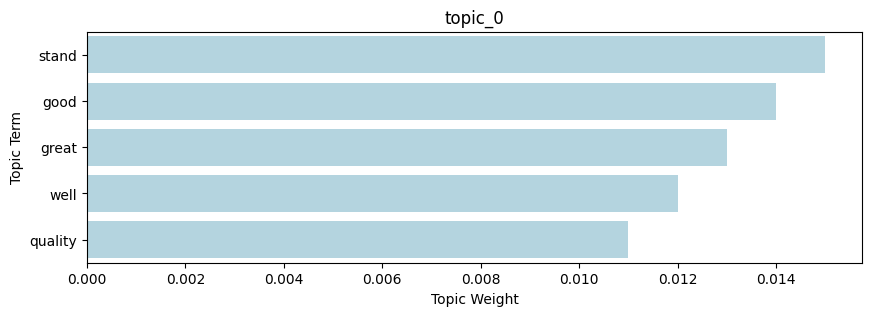

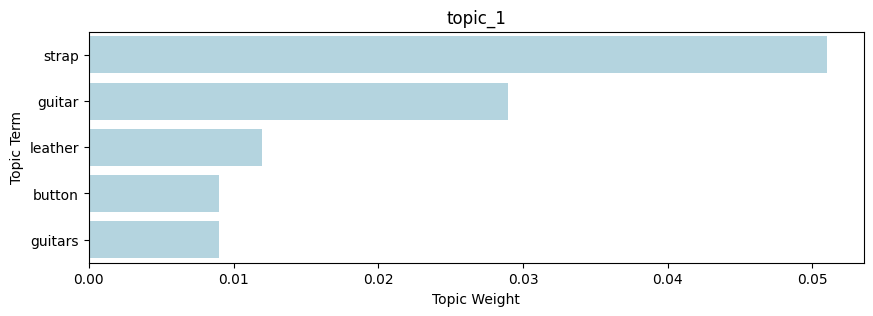

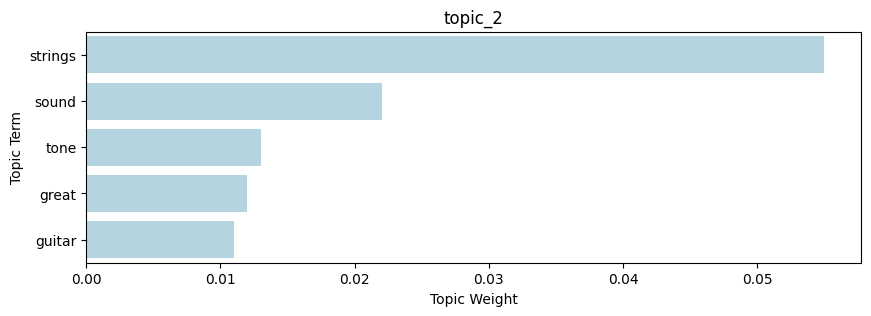

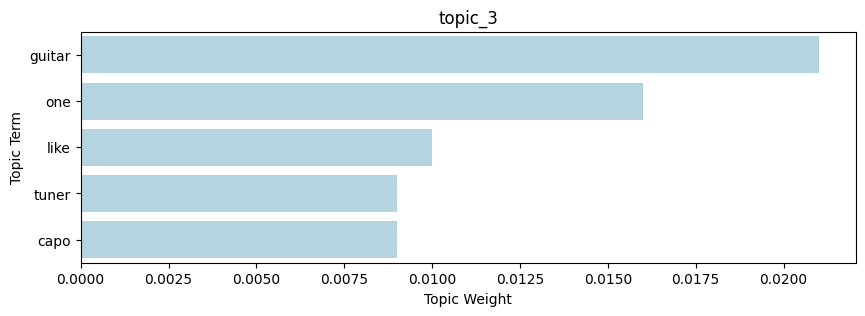

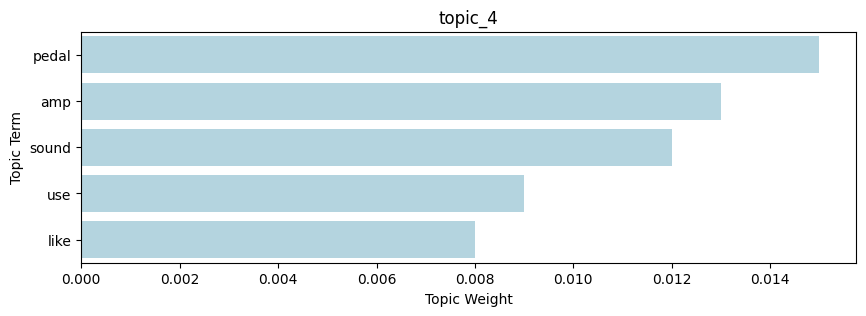

In [11]:
# Group the data by topic
amazon_topic_list =  amazon_topic_res["Topic"].unique().tolist()

# Create a bar chart for each topic using Seaborn
for topic in amazon_topic_list:
    plt.figure(figsize=(10, 3))
    # get top 5
    topic_data = (amazon_topic_res
                  .query('Topic == @topic')
                  .nlargest(5, 'Topic_Weight'))
    sns.barplot(x='Topic_Weight', y='Topic_Term', data=topic_data, color='lightblue')
    plt.title(topic)
    plt.xlabel('Topic Weight')
    plt.ylabel('Topic Term')
    plt.show()

## Wordcloud! 

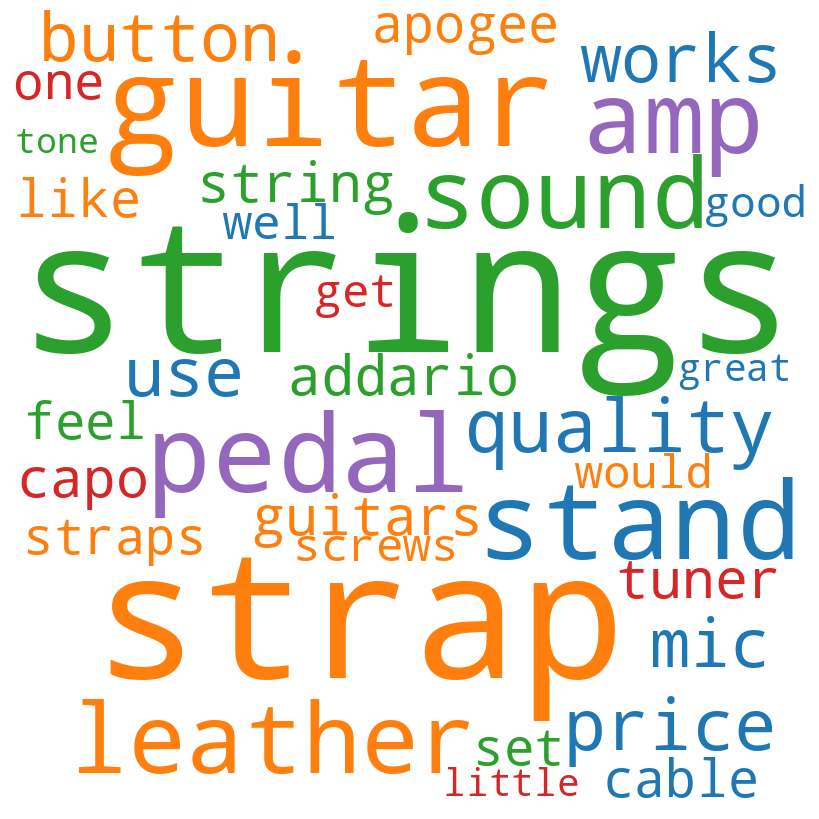

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap

# Convert the word weights to integers
amazon_topic_res['Topic_Weight_int'] = (1000*amazon_topic_res['Topic_Weight']).astype(int)

# Create a dictionary of word frequencies
word_freq = dict(zip(amazon_topic_res['Topic_Term'], amazon_topic_res['Topic_Weight_int']))

# Define the colors for each topic
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Create a color map with a different color for each topic
color_map = ListedColormap(colors)

# Define a function to get the color of a word based on its topic
def get_color(word, font_size, position, orientation, random_state=None, **kwargs):
    topic = amazon_topic_res.loc[amazon_topic_res['Topic_Term'] == word, 'Topic'].iloc[0]
    topic_idx = amazon_topic_res['Topic'].unique().tolist().index(topic)
    return colors[topic_idx]

# Create a word cloud with different color for each topic
wordcloud = WordCloud(background_color='white', width=800, height=800, colormap=color_map,
                      prefer_horizontal=1.0, color_func=get_color).generate_from_frequencies(word_freq)

# Display the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


# BERT Topic 


---

BERTopic is a topic modeling algorithm that leverages the BERT language model to generate embeddings for text data. It was introduced in the paper "BERTopic: Efficient and effective topic modeling with contextualized embeddings" by Joren Six, Tim Van de Cruys, and Marie-Francine Moens.

Why use BERTopic vs LDA? Traditional topic modeling algorithms, such as Latent Dirichlet Allocation (LDA), use **bag-of-words representations** to model topics. This approach has some limitations, mainly not taking into account word order and context.

BERTopic addresses these limitations by using BERT to generate document embeddings, which capture both word order and context. These embeddings are then clustered using an implementation of Hierarchical Density-Based Spatial Clustering of Applications with Noise (HDBSCAN) algorithm to identify topics.

BERTopic has been shown to outperform traditional topic modeling algorithms on a range of text datasets, while also being faster and more scalable than other state-of-the-art methods.

Anyway, it generates "better" but more complex topics. let's see it in action. 

In [26]:
# Load data
amazon_reviews = pd.read_csv('https://raw.githubusercontent.com/MonkeyWrenchGang/MGTPython/main/module_9/data/Musical_instruments_reviews.csv')


# Convert reviewText column to string
amazon_reviews['reviewText'] = amazon_reviews['reviewText'].astype(str)  

# Cast the reviews to a list 
reviews = amazon_reviews['reviewText'].values.tolist()

# get your stopwords
nltk.download('stopwords')
STOPWORDS = set(nltk.corpus.stopwords.words('english'))

# Define custom stopwords
custom_stopwords = ["the", "and", "a", "an", "in", "amp",
                    "it"
                    "these","of", "to", "is", "that", "it", "with", "for", "on", "was", "as", "this", "at", "but", "not", "be", "from", "by", "or", "if", "you", "are", "they", "can", "all", "my", "have", "has", "had", "been", "which", "there", "so", "than", "them", "their", "when", "who", "how", "what", "where", "why", "will", "would", "could"]

# Remove custom stopwords from reviews
reviews = [text.lower() for text in reviews]
reviews = [' '.join([word for word in text.split() if word not in custom_stopwords]) for text in reviews]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:

# Enable GPU acceleration for SentenceTransformer
device = 'cuda' if torch.cuda.is_available() else 'cpu'
transformer_model = SentenceTransformer('bert-base-nli-mean-tokens', device=device)

# Train BERTopic model LET IT RUNN! 
model = BERTopic(embedding_model=transformer_model, n_gram_range=(1,3))
topics, _ = model.fit_transform(reviews)

# Extract topics
topic_words = model.get_topics()
print("training complete")


training complete


In [28]:
# Convert the dictionary into a Pandas DataFrame
bert_topics = pd.DataFrame([(topic_id, term, weight) for topic_id, terms in topic_words.items() for term, weight in terms],
                  columns=['topic_id', 'term', 'weight'])

bert_topics.head(20)

topic_id     term    weight
0         -1       it  0.005796
1         -1   guitar  0.005516
2         -1      one  0.004936
3         -1    these  0.004842
4         -1     like  0.004554
5         -1    great  0.004418
6         -1    sound  0.004393
7         -1     just  0.004345
8         -1      use  0.004342
9         -1     very  0.004288
10         0    great  0.014187
11         0     very  0.012703
12         0     good  0.011436
13         0     easy  0.011174
14         0     well  0.010796
15         0    works  0.010109
16         0     nice  0.009393
17         0    price  0.009086
18         0       it  0.008780
19         0  quality  0.008319

In [29]:
# need to make an integer to visualize w. a wordcloud! 
bert_topics["weight_int"] = (bert_topics["weight"]*10000).astype(int)
bert_topics.head()

topic_id    term    weight  weight_int
0        -1      it  0.005796          57
1        -1  guitar  0.005516          55
2        -1     one  0.004936          49
3        -1   these  0.004842          48
4        -1    like  0.004554          45

topic id: -1


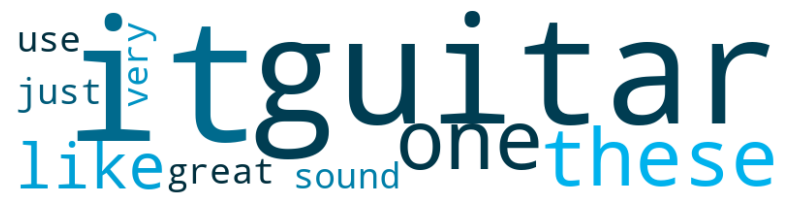

topic id: 0


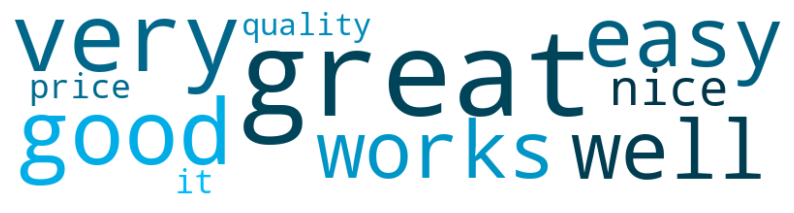

topic id: 1


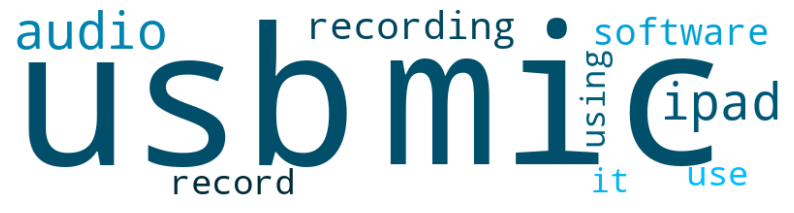

topic id: 2


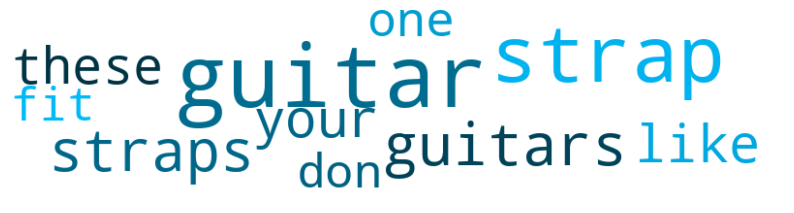

topic id: 3


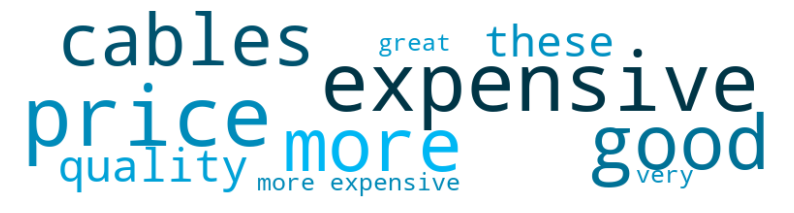

topic id: 4


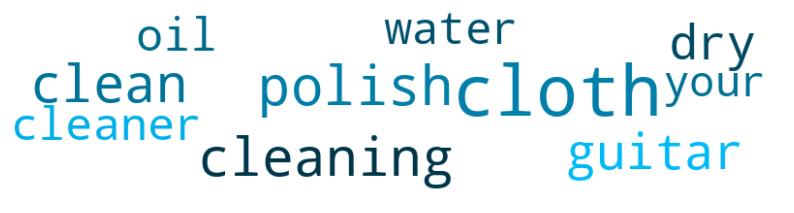

topic id: 5


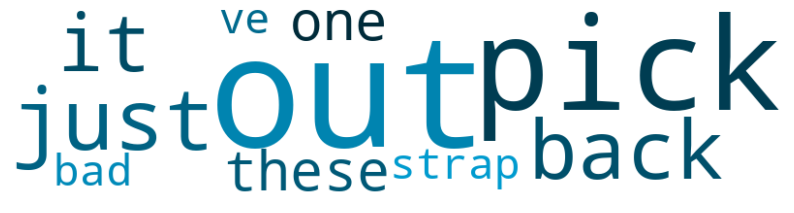

topic id: 6


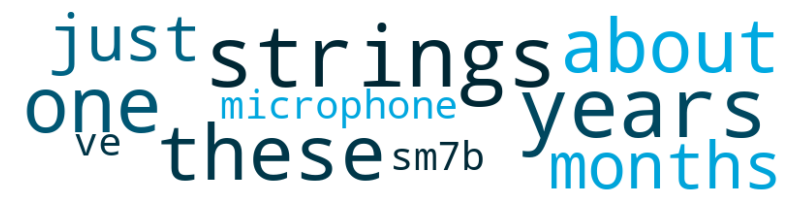

topic id: 7


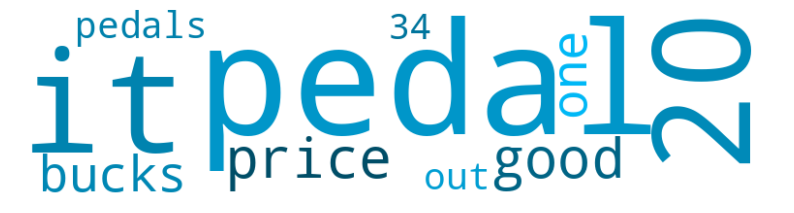

topic id: 8


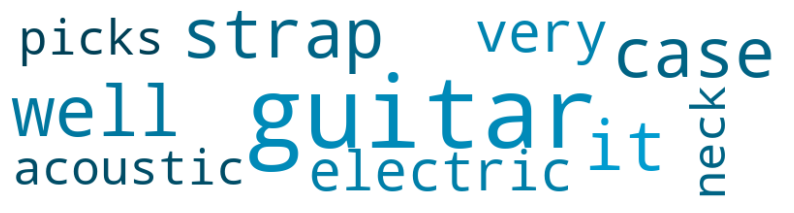

topic id: 9


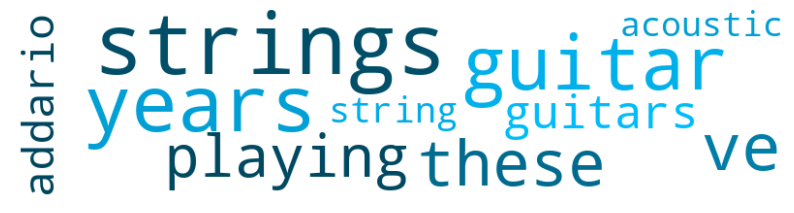

topic id: 10


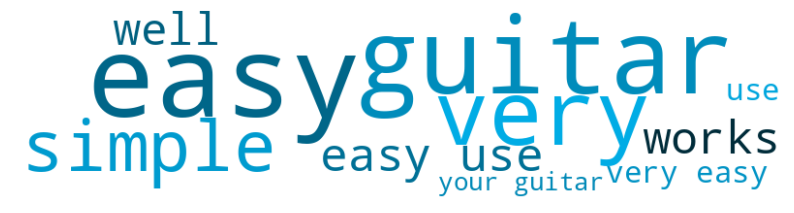

topic id: 11


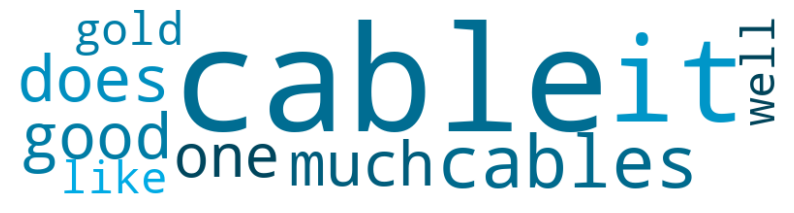

topic id: 12


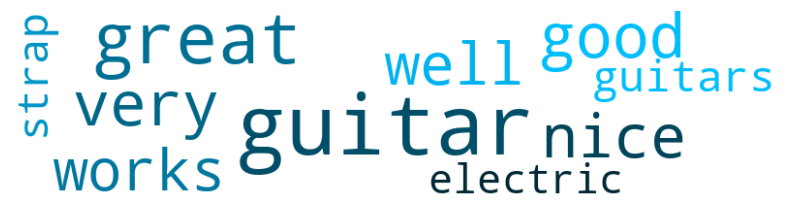

topic id: 13


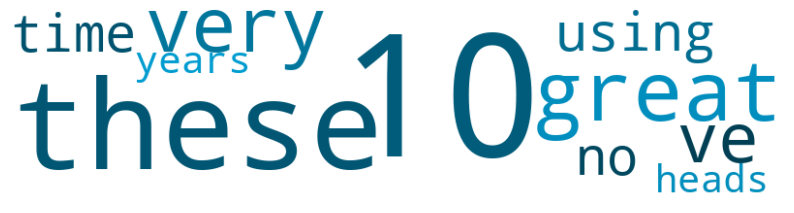

topic id: 14


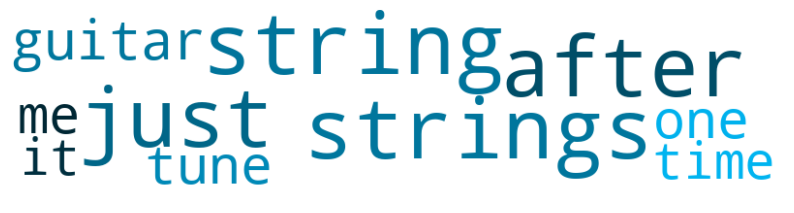

topic id: 15


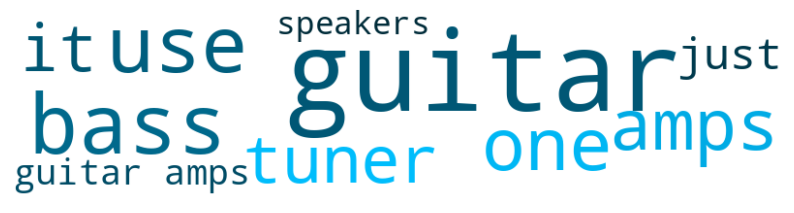

topic id: 16


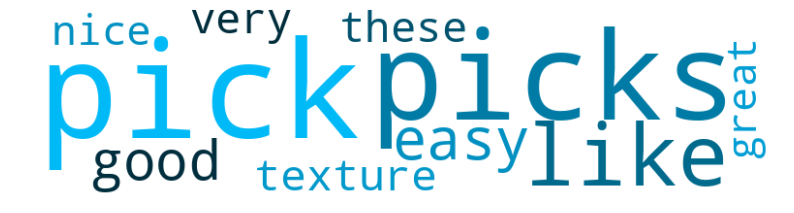

topic id: 17


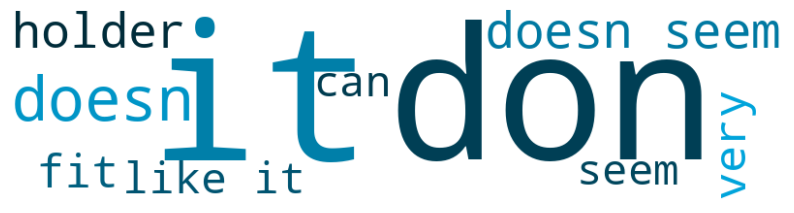

topic id: 18


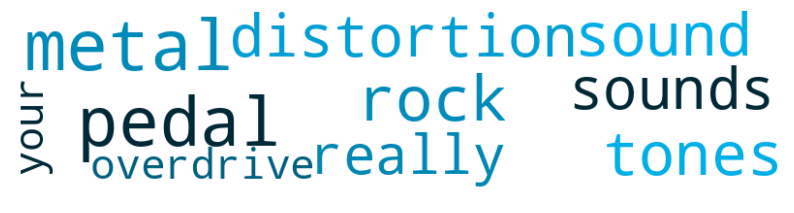

topic id: 19


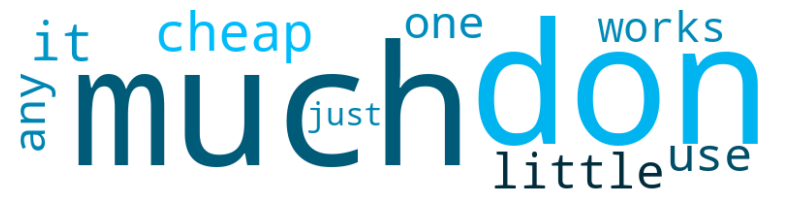

topic id: 20


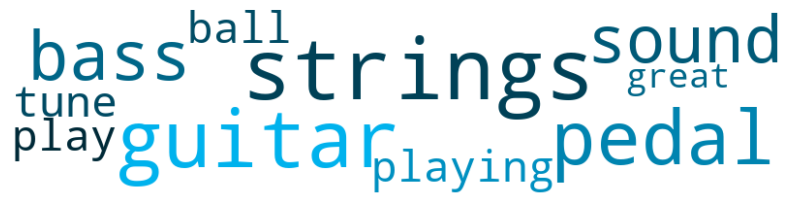

topic id: 21


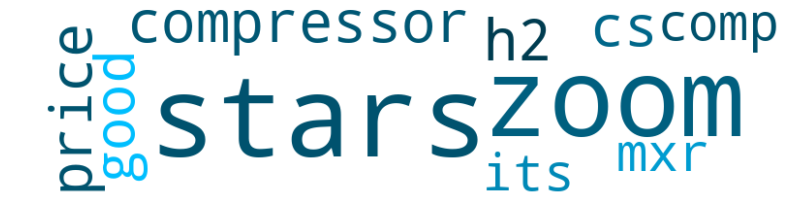

topic id: 22


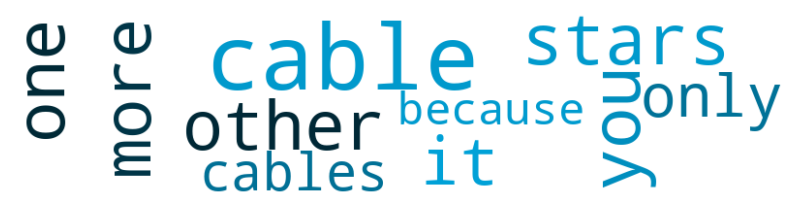

topic id: 23


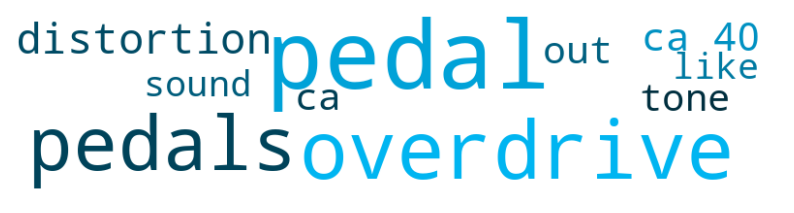

topic id: 24


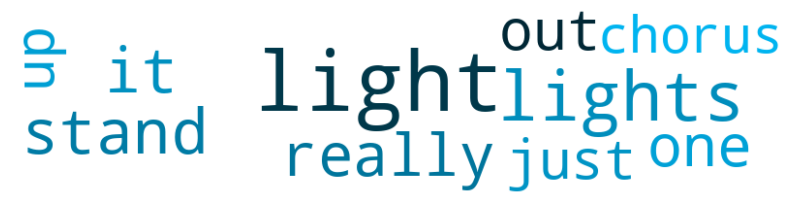

topic id: 25


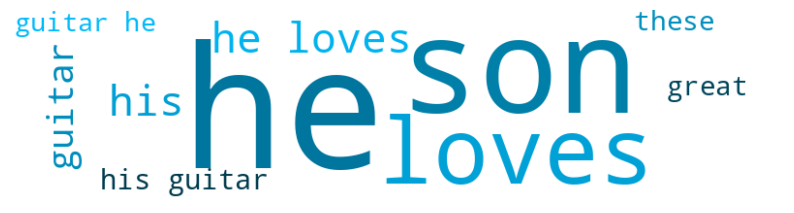

topic id: 26


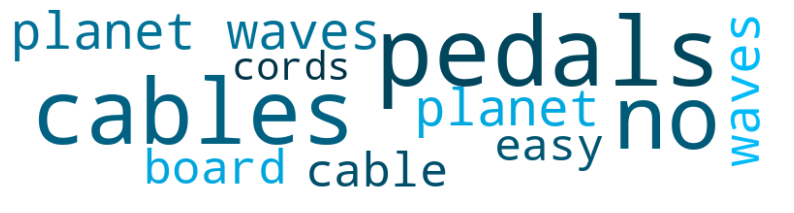

topic id: 27


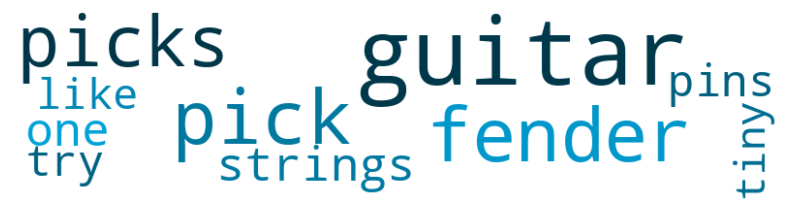

topic id: 28


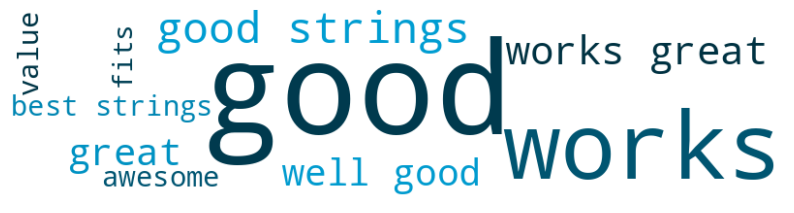

topic id: 29


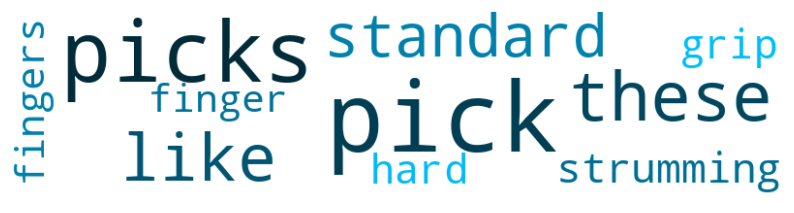

topic id: 30


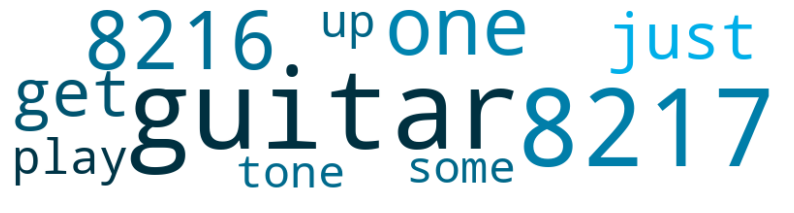

topic id: 31


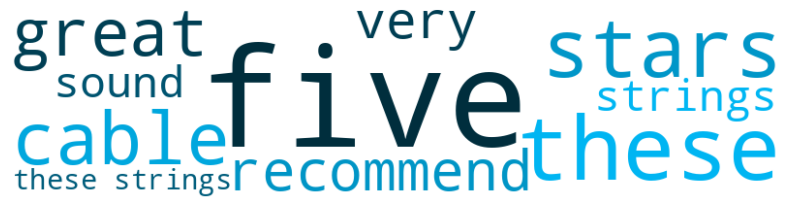

topic id: 32


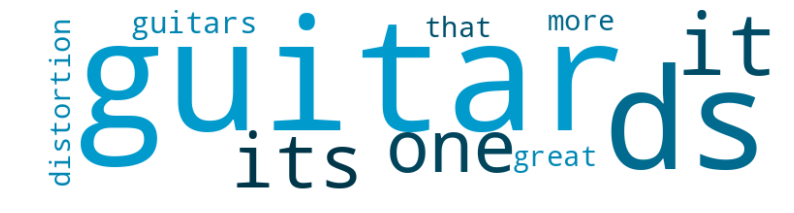

topic id: 33


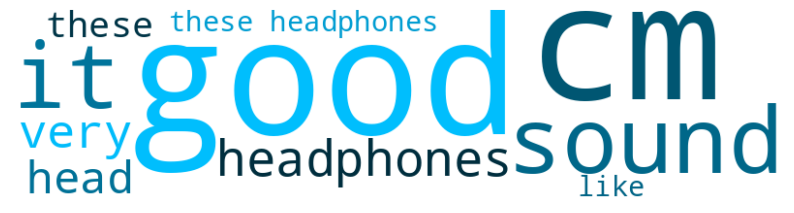

topic id: 34


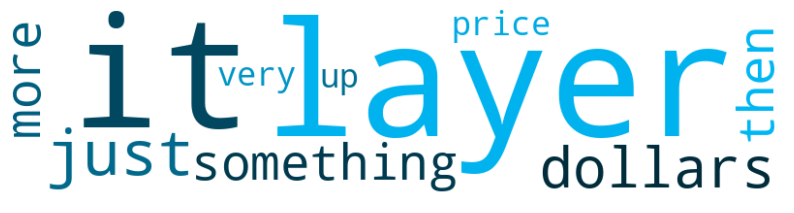

topic id: 35


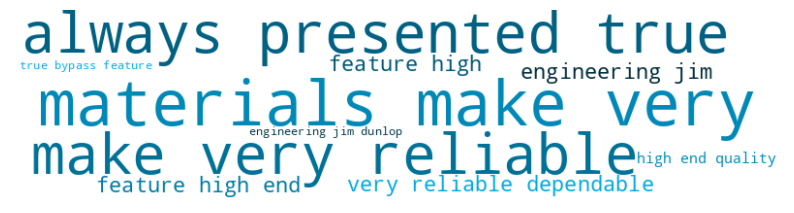

topic id: 36


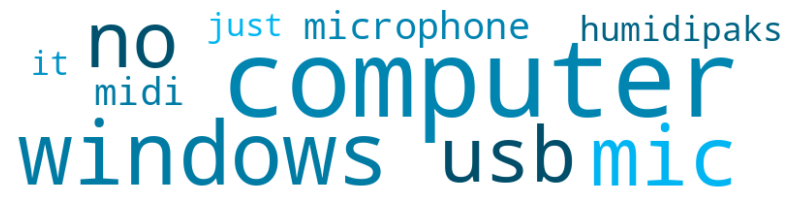

topic id: 37


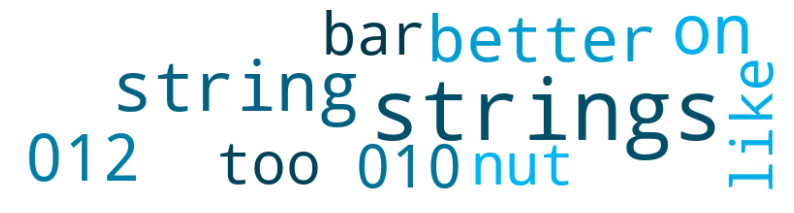

topic id: 38


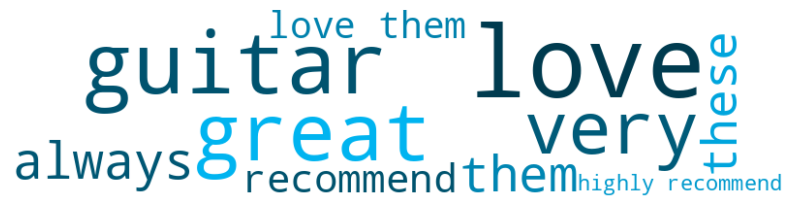

topic id: 39


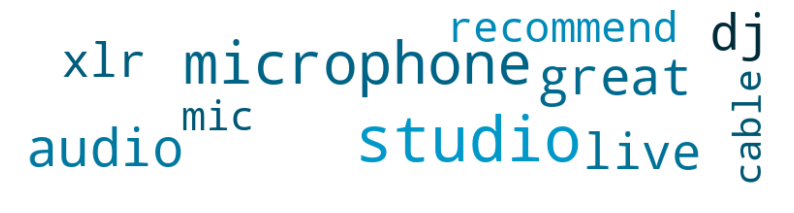

topic id: 40


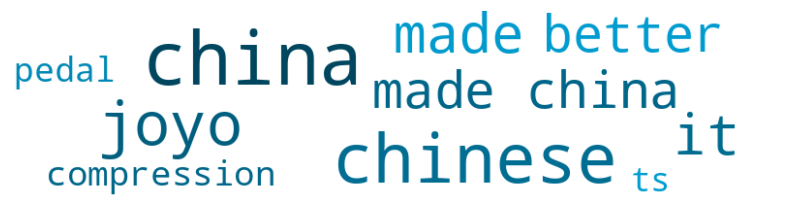

topic id: 41


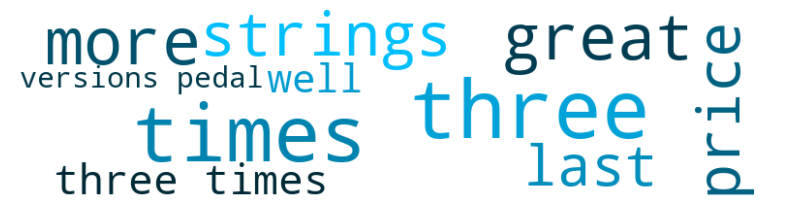

topic id: 42


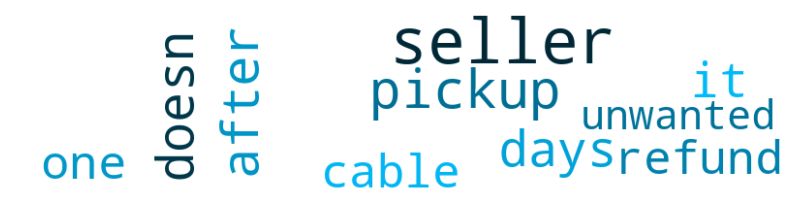

topic id: 43


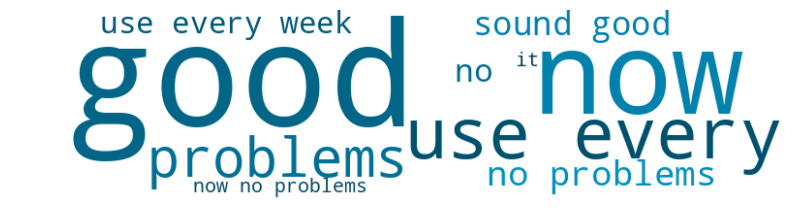

topic id: 44


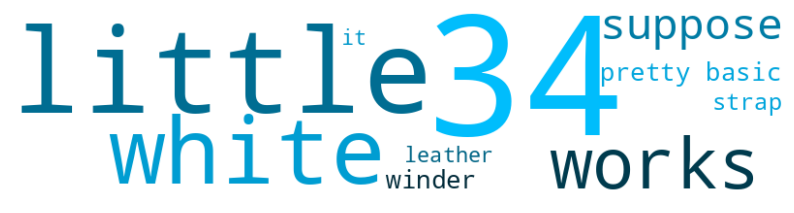

topic id: 45


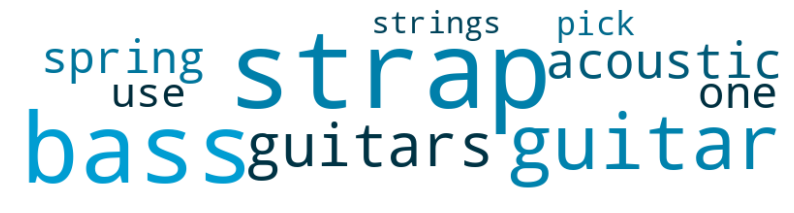

topic id: 46


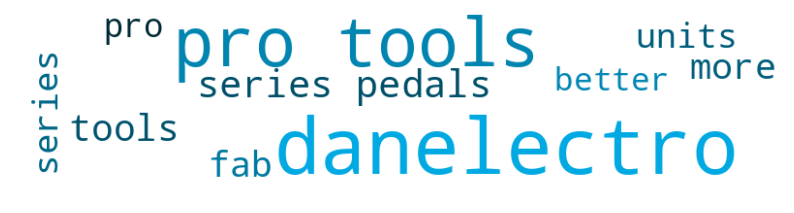

topic id: 47


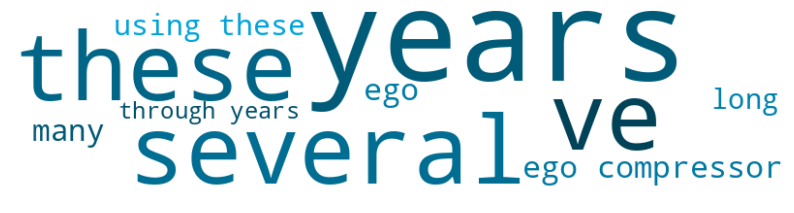

topic id: 48


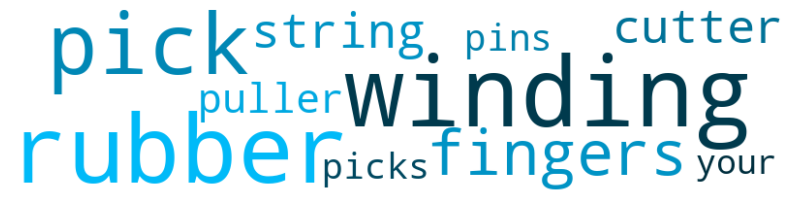

topic id: 49


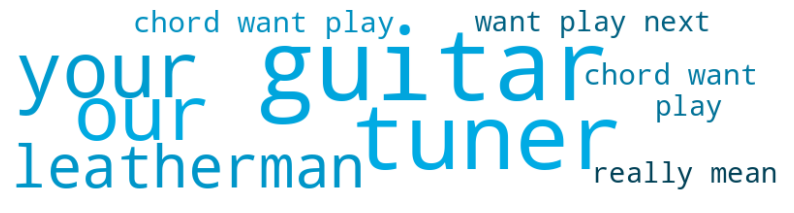

topic id: 50


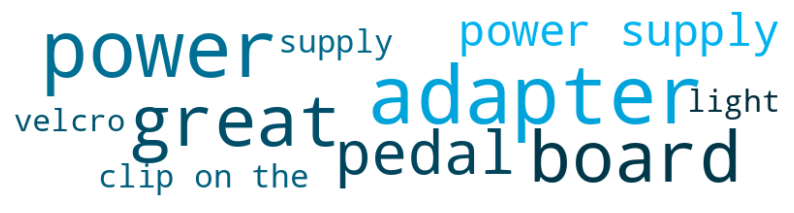

topic id: 51


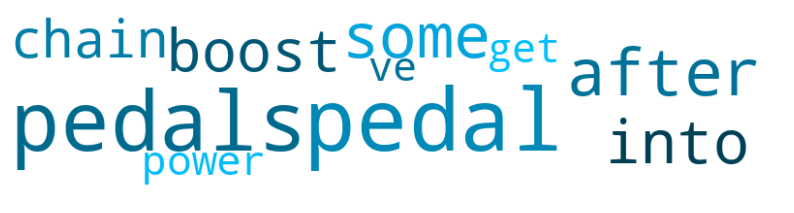

topic id: 52


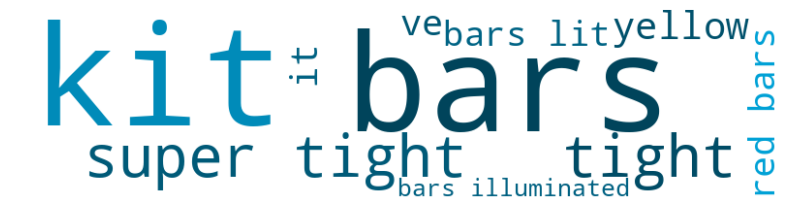

topic id: 53


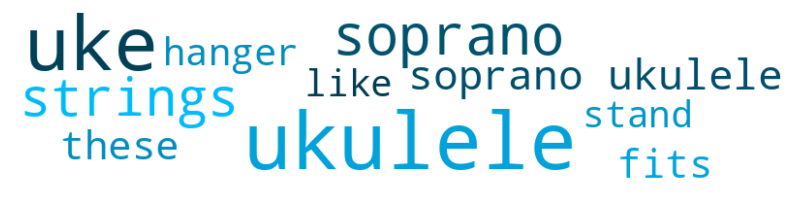

topic id: 54


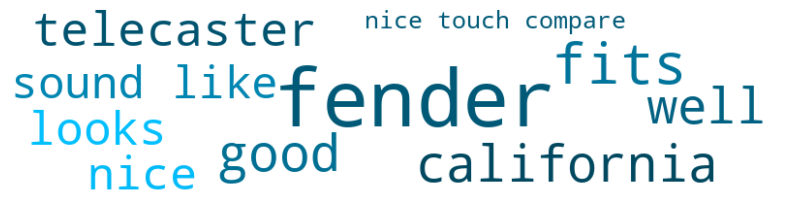

topic id: 55


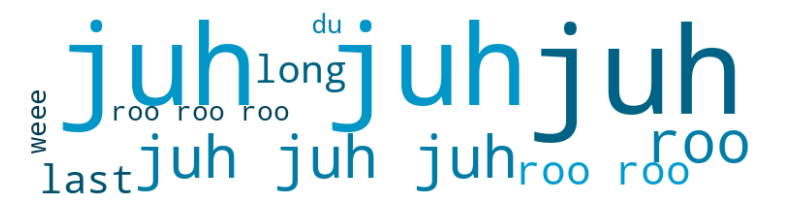

topic id: 56


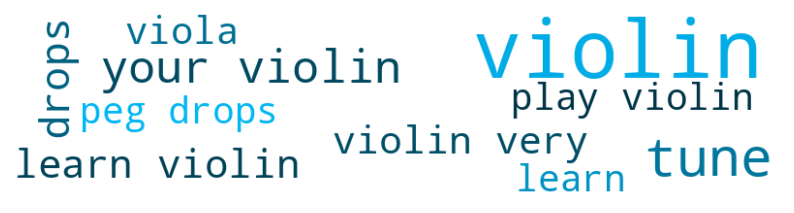

topic id: 57


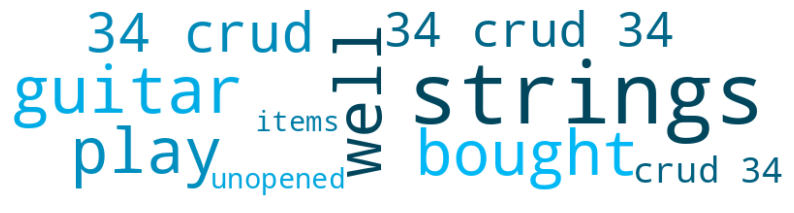

topic id: 58


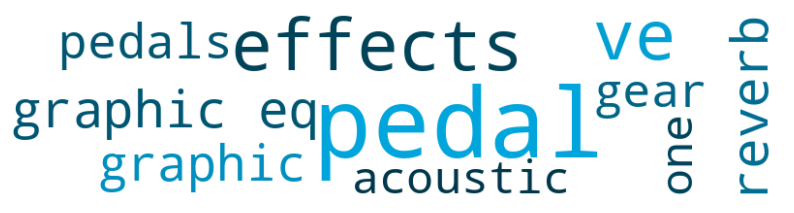

topic id: 59


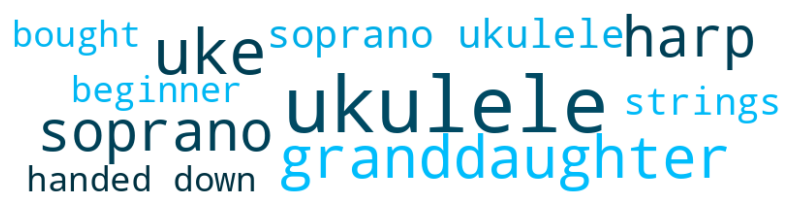

topic id: 60


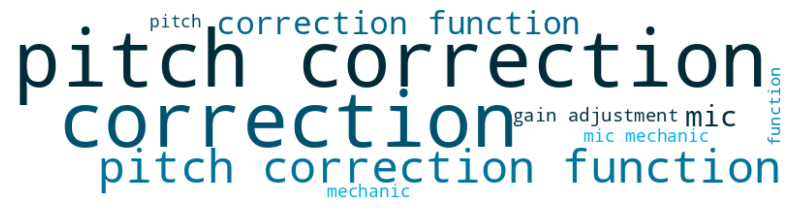

topic id: 61


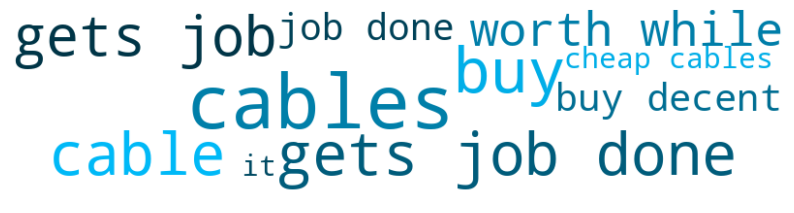

topic id: 62


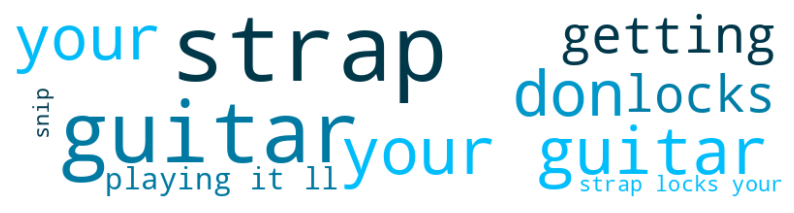

topic id: 63


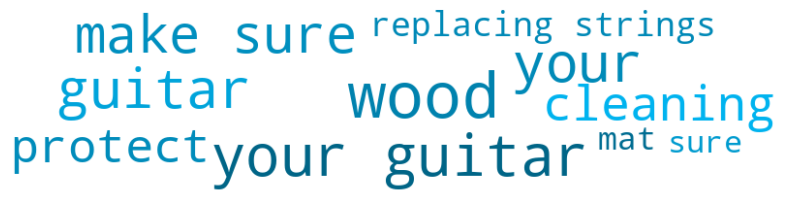

topic id: 64


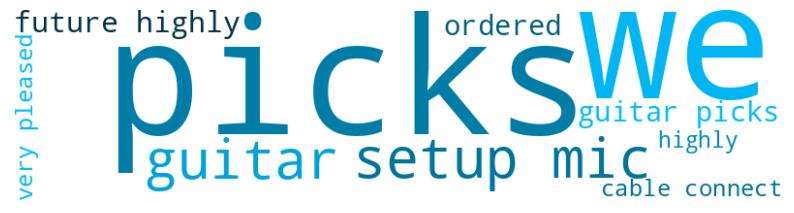

topic id: 65


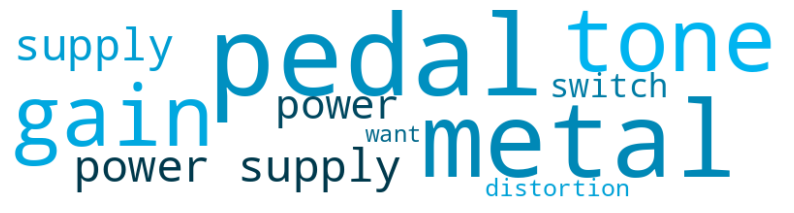

topic id: 66


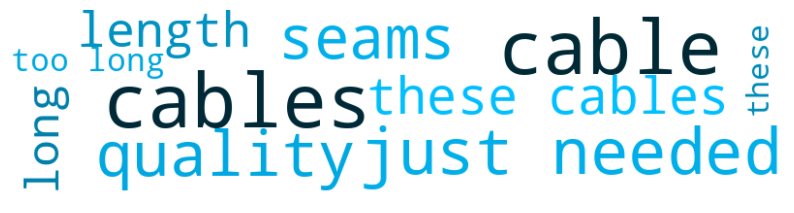

topic id: 67


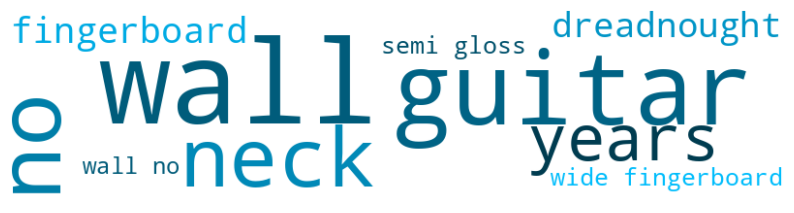

topic id: 68


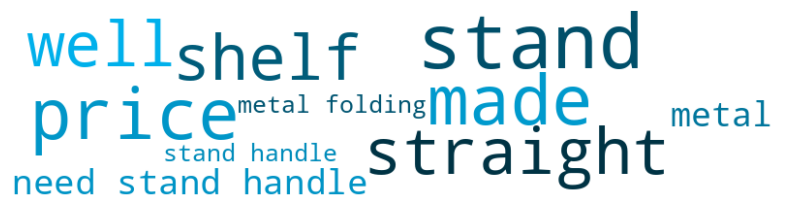

topic id: 69


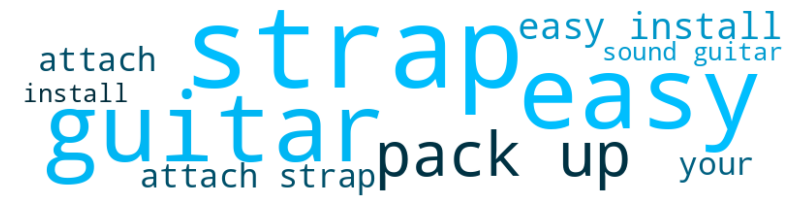

topic id: 70


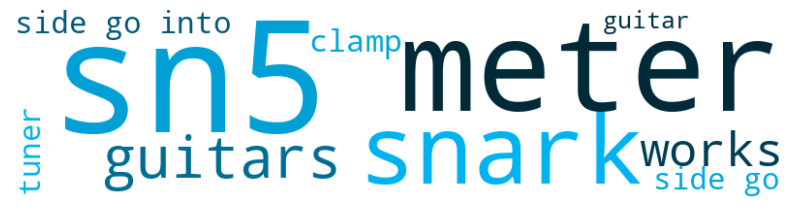

topic id: 71


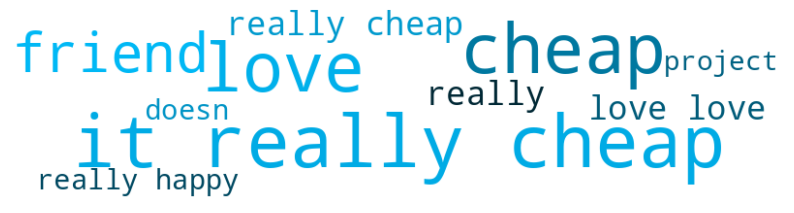

In [30]:
import numpy as np 
from wordcloud import get_single_color_func
topic_id_list = bert_topics["topic_id"].unique().tolist()

  # Define a function to generate random colors
def random_color(word, font_size, position, orientation, random_state=None, **kwargs):
      return tuple(np.random.randint(0, 255, 3))

# Generate word cloud for each topic
for topic in topic_id_list:
  print("topic id: {}".format(topic))
  topic_df = bert_topics.query("topic_id == @topic")
  # Create a dictionary of word frequencies
  word_freq = dict(zip(topic_df['term'], topic_df['weight_int']))

  # Generate the word cloud
  wordcloud = WordCloud(width=800, height=200, background_color='white', color_func=get_single_color_func('deepskyblue')).generate_from_frequencies(word_freq)

  # Display the word cloud
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()
